<a href="https://colab.research.google.com/github/MonikSense/Traffic_Accident/blob/main/Paper1NEMGCNN2IMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torch-geometric scikit-learn networkx seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00


Original shape: (840, 14)
Unique target classes: [0 1]
After preprocessing: (798, 33)
Graph constructed: (798, 798)
Training completed
NE-MGCNN Accuracy: 0.9060150375939849


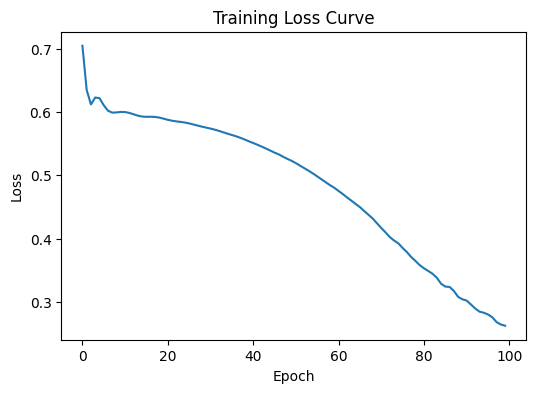

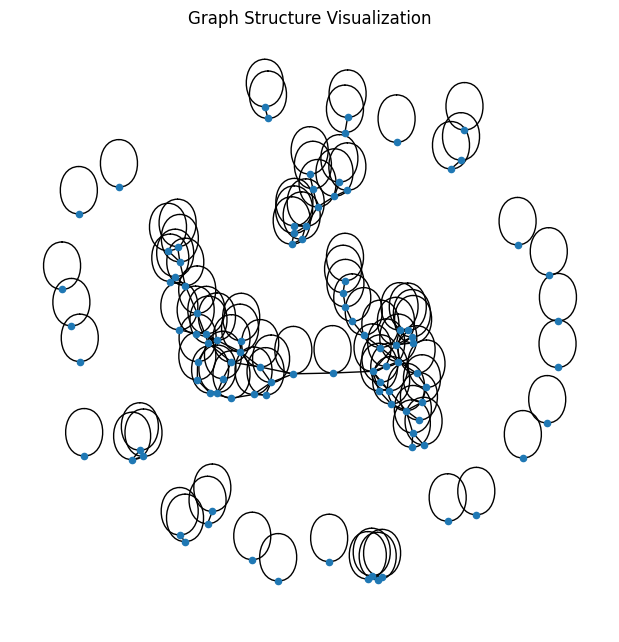

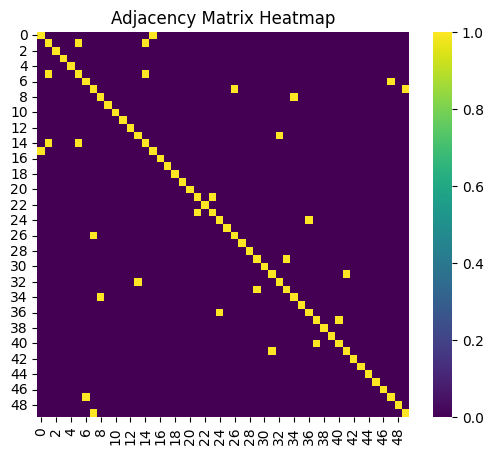

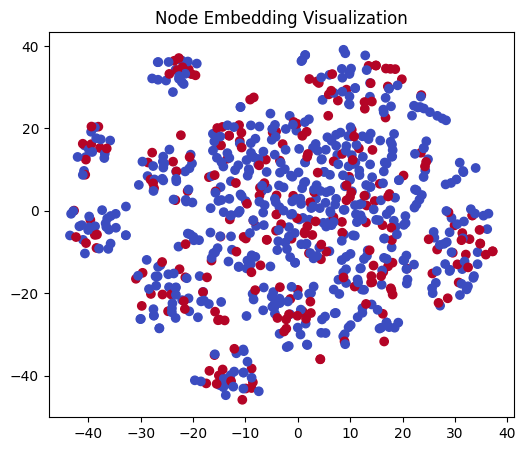

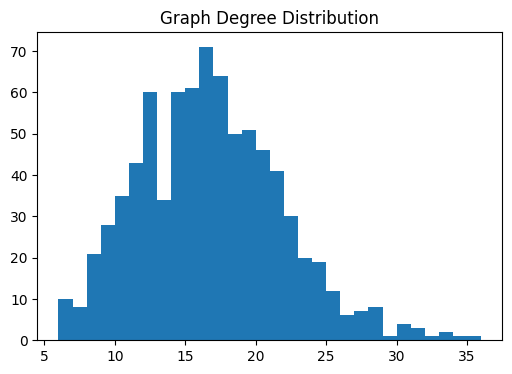

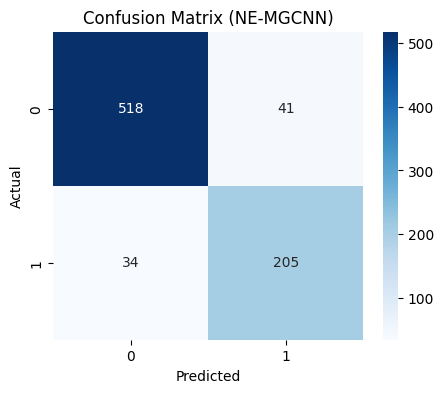

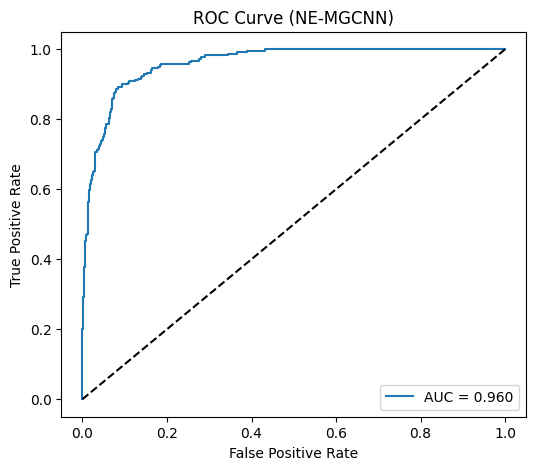

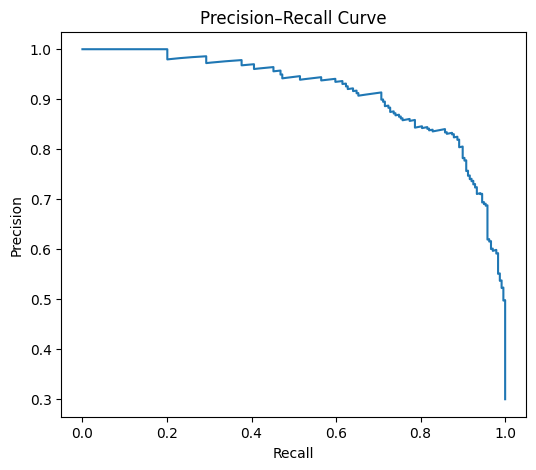

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       559
           1       0.83      0.86      0.85       239

    accuracy                           0.91       798
   macro avg       0.89      0.89      0.89       798
weighted avg       0.91      0.91      0.91       798



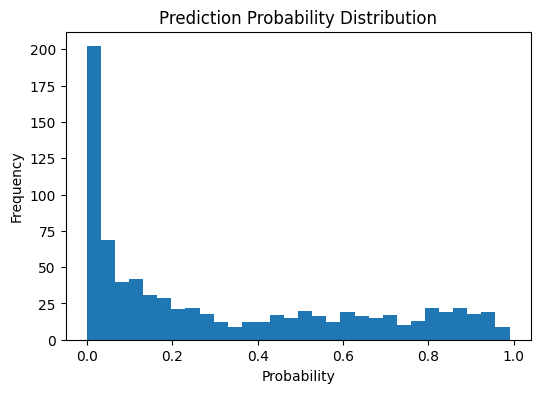

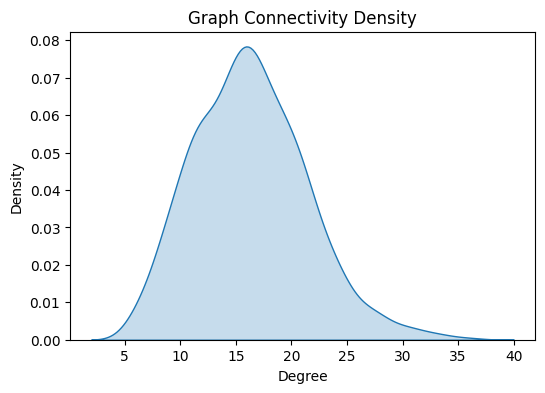

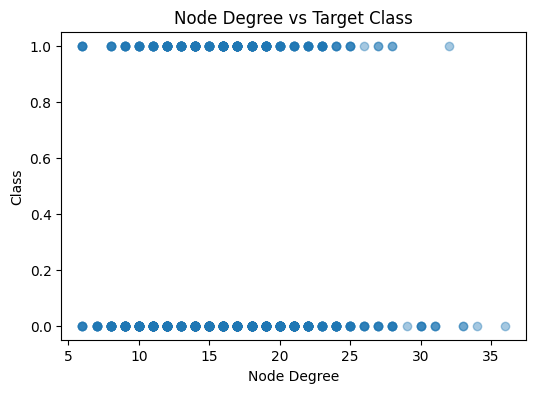

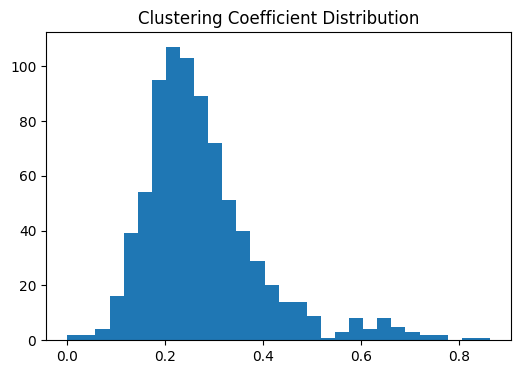

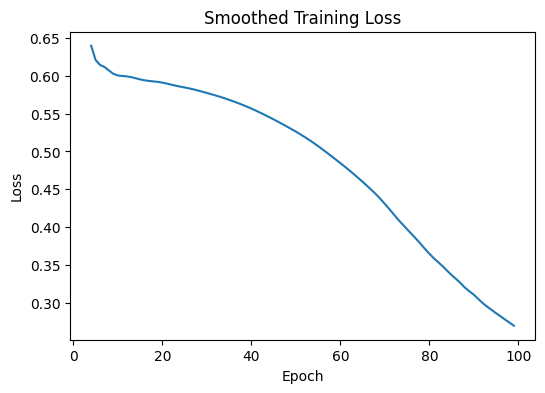

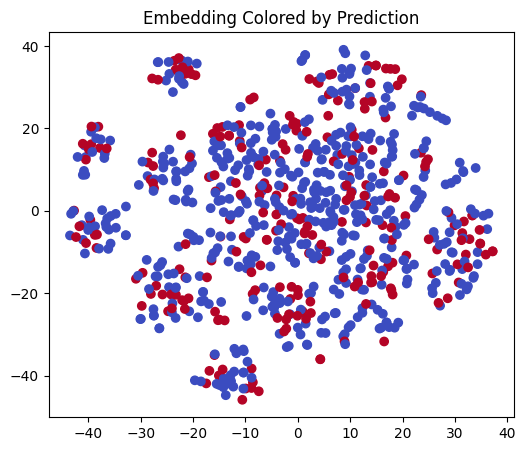

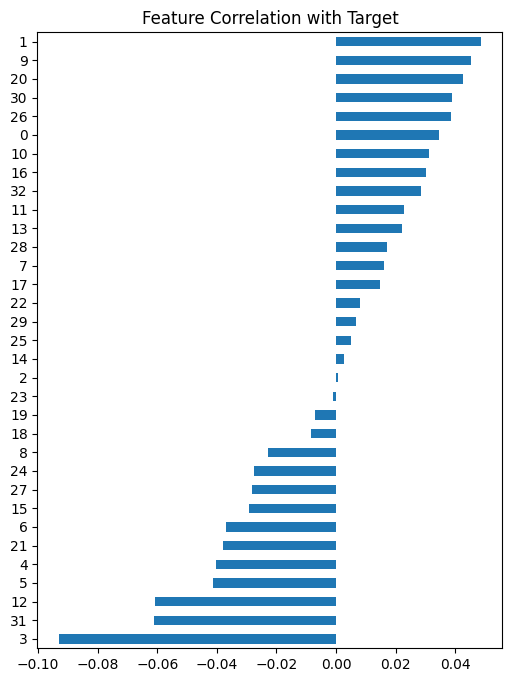

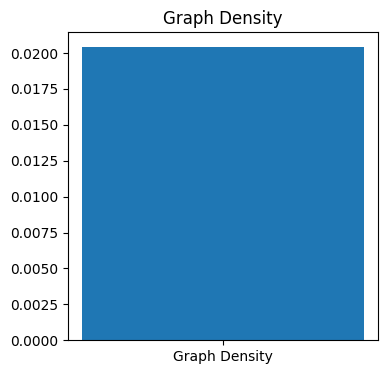

Pipeline finished successfully 🚀


In [13]:
# =============================================
# NEIGHBOR ENHANCED MULTI GRAPH CNN (FIXED)
# =============================================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# =============================================
# LOAD DATASET
# =============================================

df = pd.read_csv("https://raw.githubusercontent.com/MonikSense/Traffic_Accident/refs/heads/main/dataset_traffic_accident_prediction1.csv")

print("Original shape:", df.shape)

# =============================================
# HANDLE TARGET COLUMN FIRST
# =============================================

target_col = df.columns[-1]

# Drop rows where target is missing
df = df.dropna(subset=[target_col])

# Encode target safely
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])

print("Unique target classes:", np.unique(df[target_col]))

# =============================================
# SPLIT FEATURES AND TARGET
# =============================================

X = df.drop(columns=[target_col])
y = df[target_col]

# =============================================
# ENCODE FEATURES
# =============================================

X = pd.get_dummies(X)

# Replace infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print("After preprocessing:", X_scaled.shape)


# =============================================
# MULTI GRAPH CONSTRUCTION
# =============================================

# Graph 1 — KNN
A_knn = kneighbors_graph(
    X_scaled,
    n_neighbors=5,
    mode='connectivity',
    include_self=False
).toarray()

# Graph 2 — Cosine similarity
A_cos = cosine_similarity(X_scaled)
A_cos[A_cos < 0.7] = 0
A_cos[A_cos >= 0.7] = 1

# Graph 3 — Feature correlation similarity
corr = np.corrcoef(X_scaled)
corr = np.nan_to_num(corr)
A_corr = (np.abs(corr) > 0.5).astype(int)

# Fuse graphs
A_fused = ((A_knn + A_cos + A_corr) > 0).astype(int)

print("Graph constructed:", A_fused.shape)

# =============================================
# BUILD EDGE INDEX
# =============================================

edge_index = np.array(np.nonzero(A_fused))
edge_index = torch.tensor(edge_index, dtype=torch.long)

x_tensor = torch.tensor(X_scaled, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.long)

data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

# =============================================
# GCN MODEL
# =============================================

class NE_MGCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = torch.nn.Linear(32, len(np.unique(y)))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

model = NE_MGCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# =============================================
# TRAINING
# =============================================

losses = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Training completed")

# =============================================
# PREDICTIONS
# =============================================

model.eval()
pred = out.argmax(dim=1)
acc = accuracy_score(y, pred.numpy())

print("NE-MGCNN Accuracy:", acc)

# =============================================
# PLOTS
# =============================================

# 1️⃣ Training Loss Curve
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 2️⃣ Graph Visualization (subset)
G = nx.from_numpy_array(A_fused[:100,:100])
plt.figure(figsize=(6,6))
nx.draw(G, node_size=20)
plt.title("Graph Structure Visualization")
plt.show()

# 3️⃣ Adjacency Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(A_fused[:50,:50], cmap="viridis")
plt.title("Adjacency Matrix Heatmap")
plt.show()

# 4️⃣ t-SNE Embedding
tsne = TSNE(n_components=2, random_state=42)
emb = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(emb[:,0], emb[:,1], c=y, cmap='coolwarm')
plt.title("Node Embedding Visualization")
plt.show()

# 5️⃣ Degree Distribution
degrees = np.sum(A_fused, axis=1)
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=30)
plt.title("Graph Degree Distribution")
plt.show()

#6
plt.figure(figsize=(5,4))
cm = confusion_matrix(y, pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (NE-MGCNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Convert log probabilities to probabilities
prob = torch.exp(out).detach().numpy()

if prob.shape[1] == 2:  # Binary case
    fpr, tpr, _ = roc_curve(y, prob[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curve (NE-MGCNN)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
#8
if prob.shape[1] == 2:
    precision, recall, _ = precision_recall_curve(y, prob[:,1])

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision)
    plt.title("Precision–Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()
#9
print("Classification Report:\n")
print(classification_report(y, pred.numpy()))

#10
plt.figure(figsize=(6,4))
plt.hist(prob[:,1], bins=30)
plt.title("Prediction Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

#10
plt.figure(figsize=(6,4))
sns.kdeplot(degrees, fill=True)
plt.title("Graph Connectivity Density")
plt.xlabel("Degree")
plt.show()

#11
plt.figure(figsize=(6,4))
plt.scatter(degrees, y, alpha=0.4)
plt.title("Node Degree vs Target Class")
plt.xlabel("Node Degree")
plt.ylabel("Class")
plt.show()

#12
clustering_coeffs = list(nx.clustering(nx.from_numpy_array(A_fused)).values())

plt.figure(figsize=(6,4))
plt.hist(clustering_coeffs, bins=30)
plt.title("Clustering Coefficient Distribution")
plt.show()

#13
loss_smooth = pd.Series(losses).rolling(window=5).mean()

plt.figure(figsize=(6,4))
plt.plot(loss_smooth)
plt.title("Smoothed Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#14
plt.figure(figsize=(6,5))
plt.scatter(emb[:,0], emb[:,1], c=pred.numpy(), cmap='coolwarm')
plt.title("Embedding Colored by Prediction")
plt.show()

#15
corr_target = pd.DataFrame(X_scaled).corrwith(pd.Series(y))
corr_target = corr_target.sort_values()

plt.figure(figsize=(6,8))
corr_target.plot(kind='barh')
plt.title("Feature Correlation with Target")
plt.show()

#16
density = np.sum(A_fused) / (A_fused.shape[0]**2)

plt.figure(figsize=(4,4))
plt.bar(["Graph Density"], [density])
plt.title("Graph Density")
plt.show()


print("Pipeline finished successfully 🚀")
